# AllRecipes.com scraper

This python notebook is used to scrape recipes and users of the allrecipes.com platform in order to create a user/item matrix that will be used to design a recipes recommender system based on ingredients, recipe style, user preferences, reviews, ratings, etc...


In [1]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
import json
import os
from util import *
%matplotlib inline

endpoint = 'http://allrecipes.com/recipes/?grouping=all&page='

In [2]:
def parsePage(page):
    articlesList = []
    articles = page.find_all("article")
    for article in articles:
        if article.h3 is not None:
            name = removeSpace(article.h3.text)
            if name != "":
                print(name)
                try:
                    ratingStars = article.find("div",{"class" : "rating-stars"})["data-ratingstars"]
                    nbReviews = article.find("format-large-number")["number"]
                except:
                    ratingStars = None
                    nbReviews = None
                link = article.find('a', href=re.compile('^/recipe/'))
                if link is not None:
                    print(link['href'])
                    articlesList.append([name, ratingStars, nbReviews, link['href']])
                else:
                    link = article.find('a', href=re.compile('^/cook/'))
                    if link is not None:
                        print(link['href'])
                        articlesList.append([name, ratingStars, nbReviews, link['href']])
                    else:
                        print("REALLY NO LINKS")
    return articlesList

In [3]:
'''articlesList = []
for i in range(1, 2):
    response = urlopen(endpoint + str(i))
    html = response.read()
    page = BeautifulSoup(html, 'html.parser')
    articlesList += parsePage(page)
    print("Scraping page " + str(i))
    '''

'articlesList = []\nfor i in range(1, 2):\n    response = urlopen(endpoint + str(i))\n    html = response.read()\n    page = BeautifulSoup(html, \'html.parser\')\n    articlesList += parsePage(page)\n    print("Scraping page " + str(i))\n    '

In [4]:
'''articles = pd.DataFrame(articlesList)
articles.columns=["Recipe title", "Rating", "Reviews", "Recipe link"]
articles'''

'articles = pd.DataFrame(articlesList)\narticles.columns=["Recipe title", "Rating", "Reviews", "Recipe link"]\narticles'

In [ ]:
'''articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding='utf-8')'''

## Merging all links

In [6]:
'''articles_1000 = pd.read_csv("indexes/1000_RecipeLinks.csv")
articles_2000 = pd.read_csv("indexes/2000_RecipeLinks.csv")
articles_3000 = pd.read_csv("indexes/3000_RecipeLinks.csv")
all_articles = pd.concat([articles_1000, articles_2000, articles_3000])
all_articles.to_csv("indexes/RecipeLinks.csv", index=False, encoding='utf-8')
'''

'articles_1000 = pd.read_csv("1000_RecipeLinks.csv")\narticles_2000 = pd.read_csv("2000_RecipeLinks.csv")\narticles_3000 = pd.read_csv("3000_RecipeLinks.csv")\nall_articles = pd.concat([articles_1000, articles_2000, articles_3000])\nall_articles.to_csv("RecipeLinks.csv", index=False, encoding=\'utf-8\')\n'

## Analyzing links and number of reviews

In [7]:
all_articles = pd.read_csv("indexes/RecipeLinks.csv")
cleaned_articles = all_articles.dropna().reset_index()
del cleaned_articles['index']
reviews = cleaned_articles["Reviews"]

In [8]:
cleaned_articles.describe()

,Rating,Reviews
count,59800.000000,59800.000000
mean,3.901782,65.999532
std,1.323218,294.742222
min,0.000000,0.000000
25%,3.970000,3.000000
50%,4.330000,12.000000
75%,4.600000,42.000000
max,5.000000,10833.000000


In [9]:
print("Recipes with more than 50 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 50])))
print("Recipes with more than 100 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 100])))
print("Recipes with more than 1000 reviews: " + str(len(cleaned_articles[cleaned_articles["Reviews"] > 1000])))

Recipes with more than 50 reviews: 13089
Recipes with more than 100 reviews: 7341
Recipes with more than 1000 reviews: 507


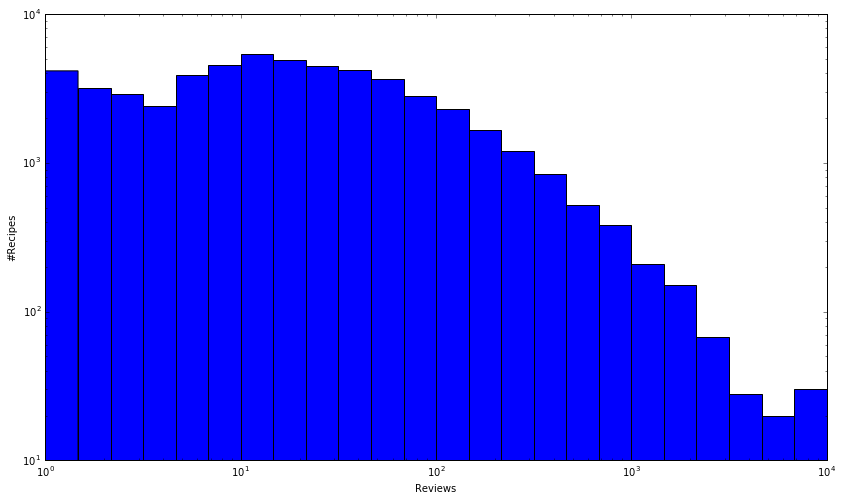

In [10]:
fig = pl.gcf()
fig.set_size_inches(14, 8)
pl.hist(reviews, bins=np.logspace(0, 4, 25))
pl.gca().set_xscale("log")
pl.gca().set_yscale("log")
pl.xlabel('Reviews')
pl.ylabel('#Recipes')
pl.show()

# Scraping recipe

In [11]:
recipe_endpoint = "http://allrecipes.com"

In [12]:
def parseRecipe(recipe):
    articlesList = []
    articles = page.find_all("article")
    for article in articles:
        if article.h3 is not None:
            name = ''.join(article.h3.text.split("\n"))
            split = name.split(" ")
            name = ""
            for part in split:
                if part != "":
                    name += part + " "
            name = name[:-1]
            if name != "":
                print(name)
                try:
                    ratingStars = article.find("div",{"class" : "rating-stars"})["data-ratingstars"]
                    nbReviews = article.find("format-large-number")["number"]
                except:
                    ratingStars = None
                    nbReviews = None
                link = article.find('a', href=re.compile('^/recipe/'))
                if link is not None:
                    print(link['href'])
                    articlesList.append([name, ratingStars, nbReviews, link['href']])
                else:
                    link = article.find('a', href=re.compile('^/cook/'))
                    if link is not None:
                        print(link['href'])
                        articlesList.append([name, ratingStars, nbReviews, link['href']])
                    else:
                        print("REALLY NO LINKS")
    return articlesList

### Get all reviews of a recipe

In [13]:
reviews_endpoint = "http://allrecipes.com/recipe/getreviews/"

In [14]:
def getAllShortReviews(recipe_id, nbReviews):
    params = {
        "recipeid": recipe_id,
        "pagenumber": 1,
        "pagesize": nbReviews,
        "recipeType": "Recipe",
        "sortBy": "MostHelpful"
    }
    r = requests.get(reviews_endpoint, params=params)
    response = BeautifulSoup(r.text, 'html.parser')
    html_reviews = response.find_all("div", {"class": "review-container clearfix"})
    reviews = []
    for rev in html_reviews:
        author_ref = rev.find("a")["href"]
        author_name = removeSpace(rev.find("h4",{"itemprop":"author"}).text)
        author_infos = rev.find_all("format-large-number")
        author_followers = author_infos[0]["number"]
        author_favorites = author_infos[1]["number"]
        author_recipes = author_infos[2]["number"]
        print(rev)
        review = {"author_ref": author_ref, "author_name": author_name, "author_followers": author_followers, 
                        "author_favorites": author_favorites, "author_recipes": author_recipes}
        reviews.append(review)
        
    return reviews

In [15]:
def getRecipeReviews(endpoint, page, size, token):
    params = {
        "page": page,
        "pagesize": size,
    }

    session = requests.Session()
    r = requests.get(endpoint, params=params, headers={'Authorization': 'Bearer ' + token})
    response = json.loads(r.text)
    print("Retrieved reviews: " + str(len(response["reviews"])))
    return response["reviews"]

In [16]:
max_review = 100

def getAllRecipeReviews(endpoint, size, token):
    all_reviews = []
    nb_reviews = 0
    page = 1
    while (size - nb_reviews) > max_review:
        reviews = getRecipeReviews(endpoint, page, max_review, token)
        nb_reviews += max_review
        page += 1
        all_reviews = all_reviews + reviews
        
    reviews = getRecipeReviews(endpoint, page, (size - nb_reviews), token)
    nb_reviews += (size - nb_reviews)
    all_reviews = all_reviews + reviews
    
    return all_reviews

### Getting photos metadatas

In [17]:
def getRecipePhotos(endpoint, page, size, token):
    params = {
        "page": page,
        "pagesize": size,
    }

    session = requests.Session()
    r = requests.get(endpoint, params=params, headers={'Authorization': 'Bearer ' + token})
    response = json.loads(r.text)
    print("Retrieved photos: " + str(len(response["photos"])))
    return response["photos"]

In [18]:
max_photo = 100

def getAllRecipePhotos(endpoint, size, token):
    all_photos = []
    nb_photos = 0
    page = 1
    while (size - nb_photos) > max_photo:
        photos = getRecipePhotos(endpoint, page, max_photo, token)
        nb_photos += max_photo
        page += 1
        all_photos = all_photos + photos
        
    photos = getRecipePhotos(endpoint, page, (size - nb_photos), token)
    nb_photos += (size - nb_photos)
    all_photos = all_photos + photos
    
    return all_photos

### What to scrape for a Recipe

Interesting properties:
* Author
* Description
* \# Made it
* \# Reviews
* \# Photos
* Photos metadatas
* Ingredients
* Prep time
* Cooking time
* Nutrition facts
* Number of ratings
    * Loved it
    * Liked it
    * OK
    * Didn't like it
    * Couldn't eat it
* Instructions

In [19]:
def getRecipeInfos(recipe_page, recipe_data):
    infos = recipe_page.find("div",{"class":"total-made-it"})
    recipe_data["made_it_count"] = infos["data-ng-init"].split("(")[1].split(",")[0]
    recipe_data["reviews_count"] = infos.find("span",{"class":"review-count"}).text.split(" ")[0]
    recipe_data["photos_count"] = infos.find("format-large-number")["number"]

    recipe_data["description"] = recipe_page.find("div", {"class":"submitter__description"}).text
    recipe_data["featured_in_magazine"] = (len(recipe_page.find_all("span",{"class":"recipe-summary__magazine__font"})) > 0)

    html_ingredients = recipe_page.find_all("span", {"class":"recipe-ingred_txt added","itemprop":"ingredients"})
    ingredients = []
    for ing in html_ingredients:
        ingredients.append({"id":ing["data-id"],"text":ing.text})
    recipe_data["ingredients"] = ingredients
    
    try:
        recipe_data["ready_time"] = recipe_page.find("span",{"class":"ready-in-time"}).text
    except:
        recipe_data["ready_time"] = None
    try:
        recipe_data["prep_time"] = recipe_page.find("time", {"itemprop":"prepTime"}).text
    except:
        recipe_data["prep_time"] = None
    try:
        recipe_data["cook_time"] = recipe_page.find("time", {"itemprop":"cookTime"}).text
    except:
        recipe_data["cook_time"] = None
        
    try:
        html_nutri_facts = recipe_page.find("section", {"class":"ng-hide recipe-nutrition panel"})
        nutri_facts = {}
        nutri_facts["calories"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"calories"}).text
        nutri_facts["fatContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"fatContent"}).text
        nutri_facts["carbohydrateContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"carbohydrateContent"}).text
        nutri_facts["proteinContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"proteinContent"}).text
        nutri_facts["cholesterolContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"cholesterolContent"}).text
        nutri_facts["sodiumContent"] = html_nutri_facts.find("li",{"class":"nutrientLine__item--amount", "itemprop":"sodiumContent"}).text
        recipe_data["nutri_facts"] = nutri_facts
    except:
        recipe_data["nutri_facts"] = None
        
    instructions = list(map(lambda x: removeSpace(x.text), recipe_page.find_all("li",{"class":"step"})))
    instructions = list(filter(lambda x: (x != "" and x != None), instructions))
    recipe_data["instructions"] = instructions
                
    stars_rate = list(map(lambda x: x["style"].split(" ")[1].split("%")[0], recipe_page.find_all("div",{"class":"reviewsummary--percent"})))
    recipe_data["stars_rate"] = stars_rate

### Scrape a recipe

In [20]:
def scrape(recipe_link):

    recipe_id = recipe_link.split("/")[2]
    
    directory = 'data/' + recipe_id + "/"
    fname = directory + "photos.json"
    if os.path.isfile(fname) :
        return False
    
    session = requests.Session()
    r = requests.get("http://allrecipes.com" + recipe_link)
    recipe_page = BeautifulSoup(r.text, 'html.parser')
    token = r.cookies.get_dict()["ARToken"]

    print("Scraping Recipe with link: " + recipe_link)

    recipe_data = {}
    getRecipeInfos(recipe_page, recipe_data)
    
    if os.path.exists(directory):
        i = 3
    else:
        os.makedirs(directory)
    
    with open('data/' + recipe_id + "/data.json", 'w+') as outfile:
        json.dump(recipe_data, outfile)
    
         
    reviews_endpoint = "https://apps.allrecipes.com/v1/recipes/"+str(recipe_id) + "/reviews/"
    reviews = getAllRecipeReviews(reviews_endpoint, int(recipe_data["reviews_count"]), token)
    with open('data/' + recipe_id + "/reviews.json", 'w+') as outfile:
        json.dump(reviews, outfile)
      
    photos_endpoint = "https://apps.allrecipes.com/v1/recipes/" + str(recipe_id) + "/photos"
    photos = getAllRecipePhotos(photos_endpoint, int(recipe_data["photos_count"]), token)
    with open('data/' + recipe_id + "/photos.json", 'w+') as outfile:
        json.dump(photos, outfile)
        
    print(recipe_id + " scraped")

## Scraping all recipes

In [21]:
scraped_articles = cleaned_articles[cleaned_articles["Reviews"] > 5]
scraped_articles = scraped_articles.reset_index()
del scraped_articles["index"]
len(scraped_articles)

39201

In [22]:
import threading
import time

In [ ]:
index = 0
for recipe in scraped_articles["Recipe link"]:
    scrape(recipe)
    index += 1
    print("got " + str(index))

got 1
got 2
got 3
got 4
got 5
got 6
got 7
got 8
got 9
got 10
got 11
got 12
got 13
got 14
got 15
got 16
got 17
got 18
got 19
got 20
got 21
got 22
got 23
got 24
got 25
got 26
got 27
got 28
got 29
got 30
got 31
got 32
got 33
got 34
got 35
got 36
got 37
got 38
got 39
got 40
got 41
got 42
got 43
got 44
got 45
got 46
got 47
got 48
got 49
got 50
got 51
got 52
got 53
got 54
got 55
got 56
got 57
got 58
got 59
got 60
got 61
got 62
got 63
got 64
got 65
got 66
got 67
got 68
got 69
got 70
got 71
got 72
got 73
got 74
got 75
got 76
got 77
got 78
got 79
got 80
got 81
got 82
got 83
got 84
got 85
got 86
got 87
got 88
got 89
got 90
got 91
got 92
got 93
got 94
got 95
got 96
got 97
got 98
got 99
got 100
got 101
got 102
got 103
got 104
got 105
got 106
got 107
got 108
got 109
got 110
got 111
got 112
got 113
got 114
got 115
got 116
got 117
got 118
got 119
got 120
got 121
got 122
got 123
got 124
got 125
got 126
got 127
got 128
got 129
got 130
got 131
got 132
got 133
got 134
got 135
got 136
got 137
got 138
got 

In [ ]:
'''nb_threads = 1
index = 0

nb_made = 49

while index < len(scraped_articles):
    if (len(scraped_articles) - index) < nb_threads:
        nb_threads = (len(scraped_articles) - index)

    threads = []
    
    for i in range(nb_threads):
        print("index: " + str(i+index))
        t = threading.Thread(target=scrape,args=(scraped_articles["Recipe link"][i+index],))
        t.daemon = True
        t.start()
        threads.append(t)

    for t in threads:
        t.join()
    
    nb_made += 1
    index += nb_threads
    
    if nb_made % 50 == 0:
        time.sleep(5)'''